In [18]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay


In [10]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])
df.head()


Saving loan_data.csv to loan_data (1).csv


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1


In [11]:
target = "loan_paid_back"
X = df.drop(columns=[target, "id"])
y = df[target]

numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numerical_features, categorical_features


(['annual_income',
  'debt_to_income_ratio',
  'credit_score',
  'loan_amount',
  'interest_rate'],
 ['gender',
  'marital_status',
  'education_level',
  'employment_status',
  'loan_purpose',
  'grade_subgrade'])

In [12]:
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", make_ohe())
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", cat_pipeline, categorical_features)
])


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [14]:
pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=500))
])


In [15]:
param_grid = {
    "clf__C": [0.1, 1.0, 3.0],
    "clf__penalty": ["l2"]
}


In [16]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best CV AUC:", grid.best_score_)
print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best CV AUC: 0.9090098474116619
Best Params: {'clf__C': 1.0, 'clf__penalty': 'l2'}


In [17]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Test AUC:", roc_auc_score(y_test, y_pred_proba))


Test AUC: 0.9118714893503478


<Figure size 700x500 with 0 Axes>

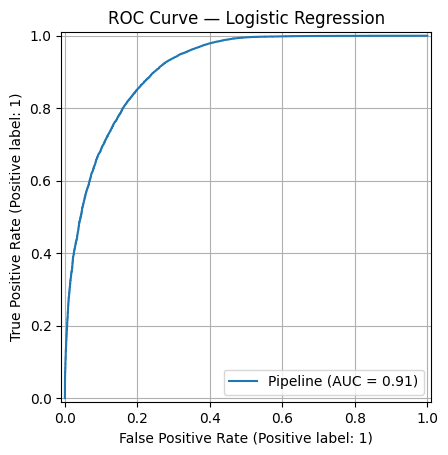

In [19]:
plt.figure(figsize=(7,5))
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve — Logistic Regression")
plt.grid(True)
plt.show()

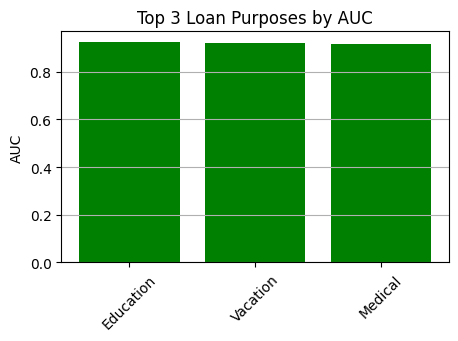

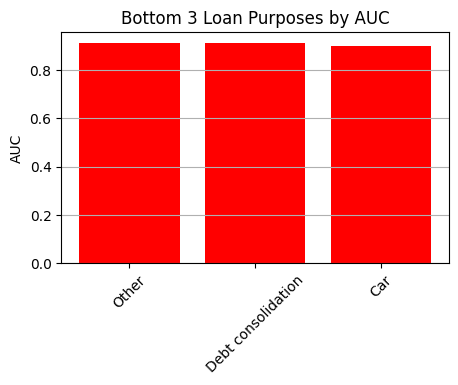

[('Education', np.float64(0.9233193402363427)),
 ('Vacation', np.float64(0.9191458333333333)),
 ('Medical', np.float64(0.918354811717659)),
 ('Home', np.float64(0.9142703926747118)),
 ('Business', np.float64(0.9116179345427028)),
 ('Other', np.float64(0.9115254132672372)),
 ('Debt consolidation', np.float64(0.9114168579918226)),
 ('Car', np.float64(0.9008508610803224))]

In [26]:
purpose_groups = X_test["loan_purpose"].unique()
auc_scores_purpose = {}

for group in purpose_groups:
    idx = X_test["loan_purpose"] == group
    if idx.sum() > 1:
        auc_scores_purpose[group] = roc_auc_score(y_test[idx], y_pred_proba[idx])

# Sort by AUC
sorted_auc = sorted(auc_scores_purpose.items(), key=lambda x: x[1], reverse=True)

top3 = dict(sorted_auc[:3])
bottom3 = dict(sorted_auc[-3:])

# Plot
plt.figure(figsize=(5,3))
plt.bar(top3.keys(), top3.values(), color='green')
plt.title("Top 3 Loan Purposes by AUC")
plt.ylabel("AUC")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(5,3))
plt.bar(bottom3.keys(), bottom3.values(), color='red')
plt.title("Bottom 3 Loan Purposes by AUC")
plt.ylabel("AUC")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

sorted_auc
